In [89]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import datetime
import os
%matplotlib inline

### Step 0. Loading dataset

In [90]:
stock = pd.read_csv('meta.us.txt')
stock.columns = ['TICKER','PER','DATE','TIME','OPEN','HIGH','LOW','CLOSE','VOL','OPENINT']
stock['TIME'] = pd.to_datetime(stock['TIME'],format='%H%M%S').dt.time
stock['DATE'] = pd.to_datetime(stock['DATE'],format='%Y%m%d').dt.date

In [91]:

print(stock.isnull().sum())                     
stock.groupby(by=["TIME"]).count()
stock = stock[(stock.TIME!=datetime.time(15,0,0))]
stock['Date-time'] = pd.to_datetime(stock.DATE.astype(str) + ' ' + stock.TIME.astype(str))
stock=stock.set_index(pd.DatetimeIndex(stock['Date-time'].values))
stock.head()                        

TICKER     0
PER        0
DATE       0
TIME       0
OPEN       0
HIGH       0
LOW        0
CLOSE      0
VOL        0
OPENINT    0
dtype: int64


,TICKER,PER,DATE,TIME,OPEN,HIGH,LOW,CLOSE,VOL,OPENINT,Date-time
2021-12-30 16:00:00,META.US,60,2021-12-30,16:00:00,344.00,345.700,343.22,345.275,1227974,0,2021-12-30 16:00:00
2021-12-30 17:00:00,META.US,60,2021-12-30,17:00:00,345.29,346.570,344.75,344.750,1365663,0,2021-12-30 17:00:00
2021-12-30 18:00:00,META.US,60,2021-12-30,18:00:00,344.80,345.383,344.17,345.366,755072,0,2021-12-30 18:00:00
2021-12-30 19:00:00,META.US,60,2021-12-30,19:00:00,345.37,345.900,345.13,345.493,544627,0,2021-12-30 19:00:00
2021-12-30 20:00:00,META.US,60,2021-12-30,20:00:00,345.49,346.696,345.28,346.535,565582,0,2021-12-30 20:00:00


In [92]:
data_to_use = stock['CLOSE'].values

In [93]:
print('Total number of data points in the dataset: {}'.format(len(data_to_use)))

Total number of data points in the dataset: 1446


### Step 1. Data preprocessing

#### Step 1.1 Scaling data

In [94]:
scaler = StandardScaler()

In [95]:
scaled_dataset = scaler.fit_transform(data_to_use.reshape(-1, 1))

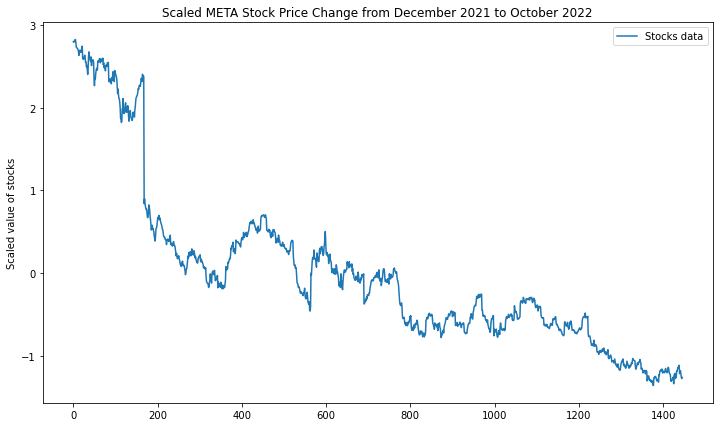

In [96]:
plt.figure(figsize=(12,7), frameon=False, facecolor='brown', edgecolor='blue')
plt.title('Scaled META Stock Price Change from December 2021 to October 2022')
plt.ylabel('Scaled value of stocks')
plt.plot(scaled_dataset, label='Stocks data')
plt.legend()
plt.show()

In [97]:
def window_data(data, window_size):
    X = []
    y = []
    
    i = 0
    while (i + window_size) <= len(data) - 1:
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
        
        i += 1
    assert len(X) ==  len(y)
    return X, y

#### Step 1.2 Windowing the dataset

In [98]:
X, y = window_data(scaled_dataset, 1)

#### Step 1.3 Creating Training and Testing sets

In [99]:
X_train  = np.array(X[:1155])
y_train = np.array(y[:1155])

X_test = np.array(X[1155:])
y_test = np.array(y[1155:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))

X_train size: (1155, 1, 1)
y_train size: (1155, 1)
X_test size: (290, 1, 1)
y_test size: (290, 1)


### Let's create the RNN

In [100]:
epochs = 50
batch_size = 2

In [101]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.compat.v1.nn.rnn_cell.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [102]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.compat.v1.random.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [103]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.compat.v1.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.optimizers.Adam(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.compat.v1.trainable_variables()))
    return loss, train_optimizer

In [104]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.0005, batch_size=2, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=1):
    
        tf.compat.v1.disable_eager_execution()
        self.inputs = tf.compat.v1.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.compat.v1.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.compat.v1.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [105]:
tf.compat.v1.reset_default_graph()
model = StockPredictionRNN()

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\layers\legacy_rnn\rnn_cell_impl.py:708: UserWarning: `tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.
  warnings.warn("`tf.nn.rnn_cell.BasicLSTMCell` is deprecated and will be "
D:\ProgramData\Anaconda3\envs\default\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Tensor("strided_slice:0", shape=(2, 512), dtype=float32)


### Time to train the network

In [106]:
session =  tf.compat.v1.Session()

In [107]:
session.run(tf.compat.v1.global_variables_initializer())

In [108]:
for i in range(epochs):
    traind_scores = []
    ii = 0
    epoch_loss = []
    while(ii + batch_size) <= len(X_train):
        X_batch = X_train[ii:ii+batch_size]
        y_batch = y_train[ii:ii+batch_size]
        
        o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})
        
        epoch_loss.append(c)
        traind_scores.append(o)
        ii += batch_size
    print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))

Epoch 0/50  Current loss: 0.2927032709121704
Epoch 1/50  Current loss: 0.019089750945568085
Epoch 2/50  Current loss: 0.002924109110608697
Epoch 3/50  Current loss: 0.0026992347557097673
Epoch 4/50  Current loss: 0.0026984186843037605
Epoch 5/50  Current loss: 0.003002522047609091
Epoch 6/50  Current loss: 0.003035019850358367
Epoch 7/50  Current loss: 0.002726248698309064
Epoch 8/50  Current loss: 0.0026982754934579134
Epoch 9/50  Current loss: 0.0028515553567558527
Epoch 10/50  Current loss: 0.00277641206048429
Epoch 11/50  Current loss: 0.0031760474666953087
Epoch 12/50  Current loss: 0.0029674486722797155
Epoch 13/50  Current loss: 0.002768764505162835
Epoch 14/50  Current loss: 0.0030504674650728703
Epoch 15/50  Current loss: 0.003238087985664606
Epoch 16/50  Current loss: 0.003141584573313594
Epoch 17/50  Current loss: 0.003212997689843178
Epoch 18/50  Current loss: 0.0034887120127677917
Epoch 19/50  Current loss: 0.00316074350848794
Epoch 20/50  Current loss: 0.00308168656192719

In [109]:
sup =[]
for i in range(len(traind_scores)):
    for j in range(len(traind_scores[i])):
        sup.append(traind_scores[i][j])

In [110]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)


In [111]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [112]:
len(tests)

145

In [113]:
test_results = []
for i in range(1446):
    if i >= 1156:
        test_results.append(tests_new[i-1156])
    else:
        test_results.append(None)

len(test_results)

1446

### Plotting predictions from the network

D:\ProgramData\Anaconda3\envs\default\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


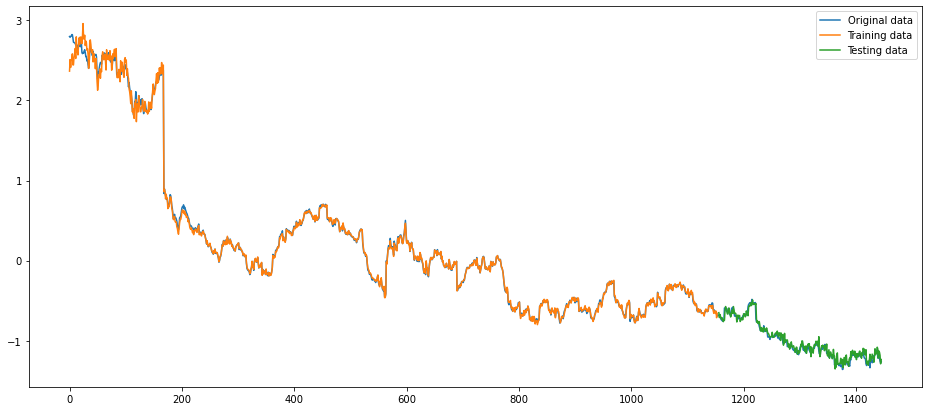

In [114]:
plt.figure(figsize=(16, 7))
plt.plot(scaled_dataset, label='Original data')
plt.plot(sup, label='Training data')
plt.plot(test_results, label='Testing data')
plt.legend()
plt.show()

In [115]:
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100  

In [116]:
def calculate_rmse(y_true, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE)  
    """
    rmse = np.sqrt(np.mean((y_true-y_pred)**2))                   
    return rmse

In [117]:
def calculate_mape(y_true, y_pred): 
    """
    Calculate the Mean Absolute Percentage Error (MAPE) %
    """
    y_pred, y_true = np.array(y_pred), np.array(y_true)    
    mape = np.mean(np.abs((y_true-y_pred) / y_true))*100    
    return mape

In [118]:
y_true = np.array(scaled_dataset[1158:1446])
y_pred= np.array(test_results[1158:1446])
mape_lstm=calculate_mape(y_true, y_pred)

In [119]:
rmse_lstm=calculate_rmse(scaler.inverse_transform(y_true), scaler.inverse_transform(y_pred))

In [120]:
print("RMSE:", '{0:.2f}'.format(rmse_lstm))
print("MAPE:",'{0:.2f}%'.format(mape_lstm))

RMSE: 2.58
MAPE: 3.75%


In [126]:
# https://cv-tricks.com/tensorflow-tutorial/save-restore-tensorflow-models-quick-complete-tutorial/
MODEL_DIR='tf_model'
version = "tensorflow_lstm"
export_path = os.path.join(MODEL_DIR, str(version))
#Save the model 
saver = tf.compat.v1.train.Saver()
saver.save(session, export_path)
# model.save(export_path, save_format="tf")
print('\nexport_path = {}'.format(export_path))
!dir {export_path}


export_path = tf_model\tensorflow_lstm
 Volume in drive D is LENOVO
 Volume Serial Number is 0A96-A90F


File Not Found



 Directory of d:\git\ytd_model_notebooks\notebooks\tf_model



In [ ]:
session.close()

### References
https://modelzoo.co/model/tesla-stocks-prediction  
https://github.com/lucko515/tesla-stocks-prediction  